# TP1

- Autor: Leandro Saraco
- Mayo 2024

## Consigna

### Parte 1 (imágenes en white_patch y coord_cromaticas) 

1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.
2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White
patch

### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘ features ’ a los
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

## Parte 1 

### 1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.

In [128]:
def coord_chromaticas_fast(img):
    """Función que implementa algoritmo de pasaje a coordenadas cromáticas de manera rápida, usando todas funciones de numpy."""    
    channels_sum = np.sum(img,axis=2) #Sumo todos los canales. img es un tensor de 996x908x3
    channels_sume_expanded = channels_sum[...,np.newaxis] #Para poder hacer broadcast y multiplicar una matrix de 996x908x3 por una de 996x908
    # Si todos los canales son 0 no hago división para evitar dividir por 0
    #  Además, si todos los canales en un punto son 0, el canal en cuestión también es 0.
    new_img = np.divide(img,channels_sume_expanded,where=channels_sume_expanded!=0)
    return new_img

def coord_chromaticas_slow(img):
    """Función que implementa algoritmo de pasaje a coordenadas cromáticas a mano, usando ciclos for."""
    channels = cv.split(img)
    channels_new = []
    channels_new_processed = []
    for ch in channels:
        channels_new.append(ch.astype(float))
    for i,ch in enumerate(channels_new):
        new_ch = np.zeros_like(ch).astype(float)
        for x in range(ch.shape[0]):
            for y in range(ch.shape[1]):
                # print(ch[x,y])
                new_ch[x,y] = 0 if ch[x,y]<=0 else ch[x,y] / (channels_new[0][x,y] + channels_new[1][x,y] + channels_new[2][x,y])
                # if y==5:
                #     return
        channels_new_processed.append(new_ch)
    new_img = cv.merge(channels_new_processed)
    return new_img


Channels sum shape: (996, 908)
Channels sum expanded: (996, 908, 1)


Text(0.5, 1.0, 'Aplicand algoritmo de coord. cromáticas')

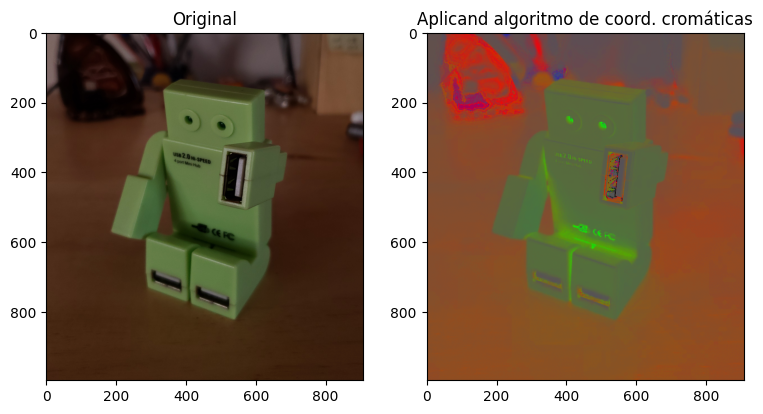

In [64]:
img = cv.imread('./coord_cromaticas/CoordCrom_2.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Nueva figura
fig = plt.figure(figsize=(9,6))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = coord_chromaticas_fast(img)
ax1.imshow(img_new)
ax1.set_title('Aplicand algoritmo de coord. cromáticas')

### 2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

In [119]:
def white_patch(img):
    """ Función que implementa algoritmo de white patch."""
    channels = cv.split(img)
    channels_new = []
    for ch in channels:
        max_ch = np.max(ch)
        mult =  255/max_ch if max_ch>0 else 0
        ch_ = ch.astype(float)
        # print(f"Max channel: {max_ch}. mult = {mult}")
        new_ch = np.round(mult*ch_,0)
        new_ch = new_ch.astype(np.uint8)
        channels_new.append(new_ch)
    new_img = cv.merge(channels_new)
    return new_img

Max channel: 255. mult = 1.0
Max channel: 134. mult = 1.9029850746268657
Max channel: 122. mult = 2.0901639344262297


Text(0.5, 1.0, 'Aplicando algoritmo de white patch')

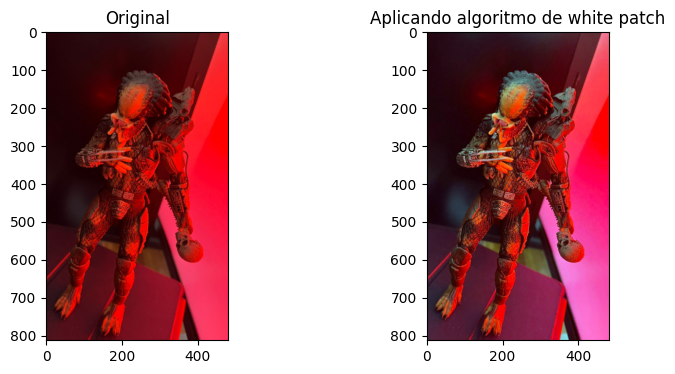

In [112]:
img = cv.imread('./white_patch/wp_red.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Nueva figura
fig = plt.figure(figsize=(9,4))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = white_patch(img)
ax1.imshow(img_new)
ax1.set_title('Aplicando algoritmo de white patch')

### 3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White Patch

- Se muestran los resultados obtenidos al procesar todas las imágenes en las carpetas 'coord_cromaticas' y 'white_patch', con su algoritmo correspondiente.

In [125]:
def procesar_y_mostrar_imagenes(folder_path,proc_function,title):
    """Funcion para procesar y mostrar todas las imagenes de una carpeta."""
    # Lita para guardar tuplas con el formato (original image, processed image, filename)
    image_pairs = []

    # Iteramos sobre todos los archivos de la carpeta
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder_path, filename)
            original_img = cv.imread(file_path)
            if original_img is not None:
                # Convierto de BGR a RGB
                original_img_rgb = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)
                # Aplico la funcion de procesado
                processed_img = proc_function(original_img_rgb)
                # Guardo todo en la tupla
                image_pairs.append((original_img_rgb, processed_img, filename))
            else:
                print(f"Error al leer imagen {filename}")

    # Mutiple plot
    plt.figure(figsize=(8, 4 * len(image_pairs)))
    plt.suptitle(title)
    for index, (original, processed, name) in enumerate(image_pairs):
        # Imagen original
        plt.subplot(len(image_pairs), 2, 2*index + 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title(f"Original: {name}")

        # Imagen procesada
        plt.subplot(len(image_pairs), 2, 2*index + 2)
        plt.imshow(processed)
        plt.axis('off')
        plt.title(f"Procesada: {name}")

    plt.tight_layout()
    plt.show()


#### Muestro todas las imagenes de ./coord_cromaticas

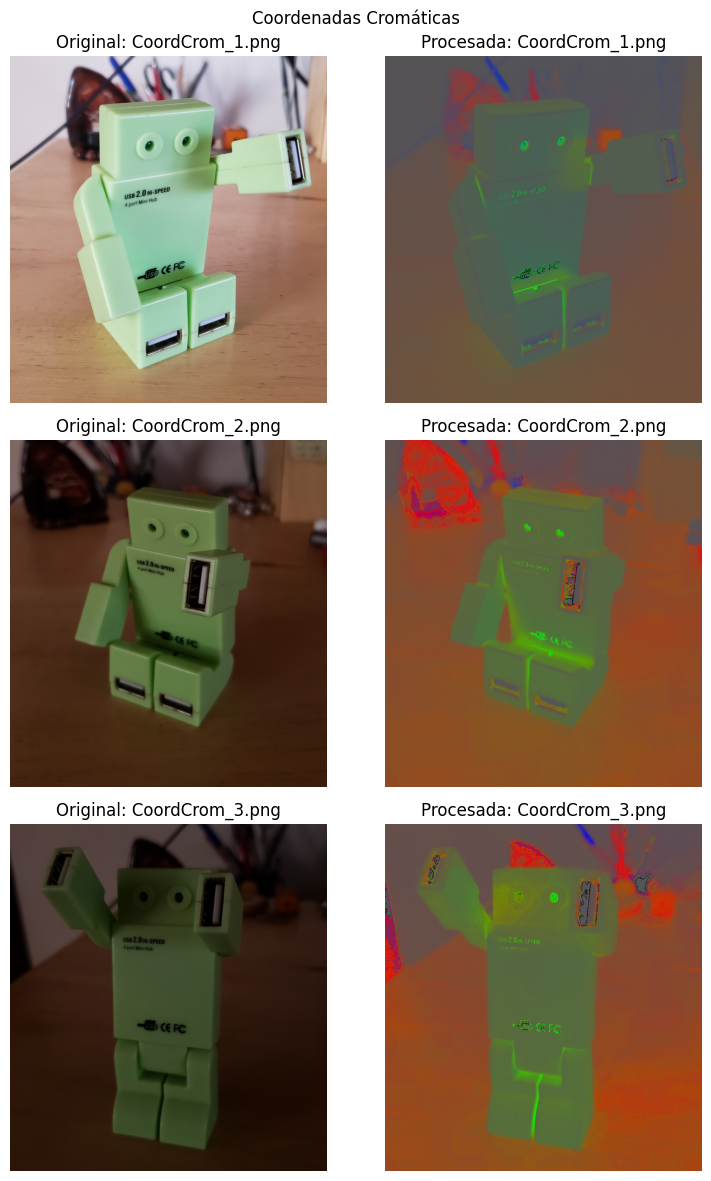

In [129]:
procesar_y_mostrar_imagenes('./coord_cromaticas',coord_chromaticas_fast,"Coordenadas Cromáticas")

#### Muestro todas las imagenes de ./white_patch

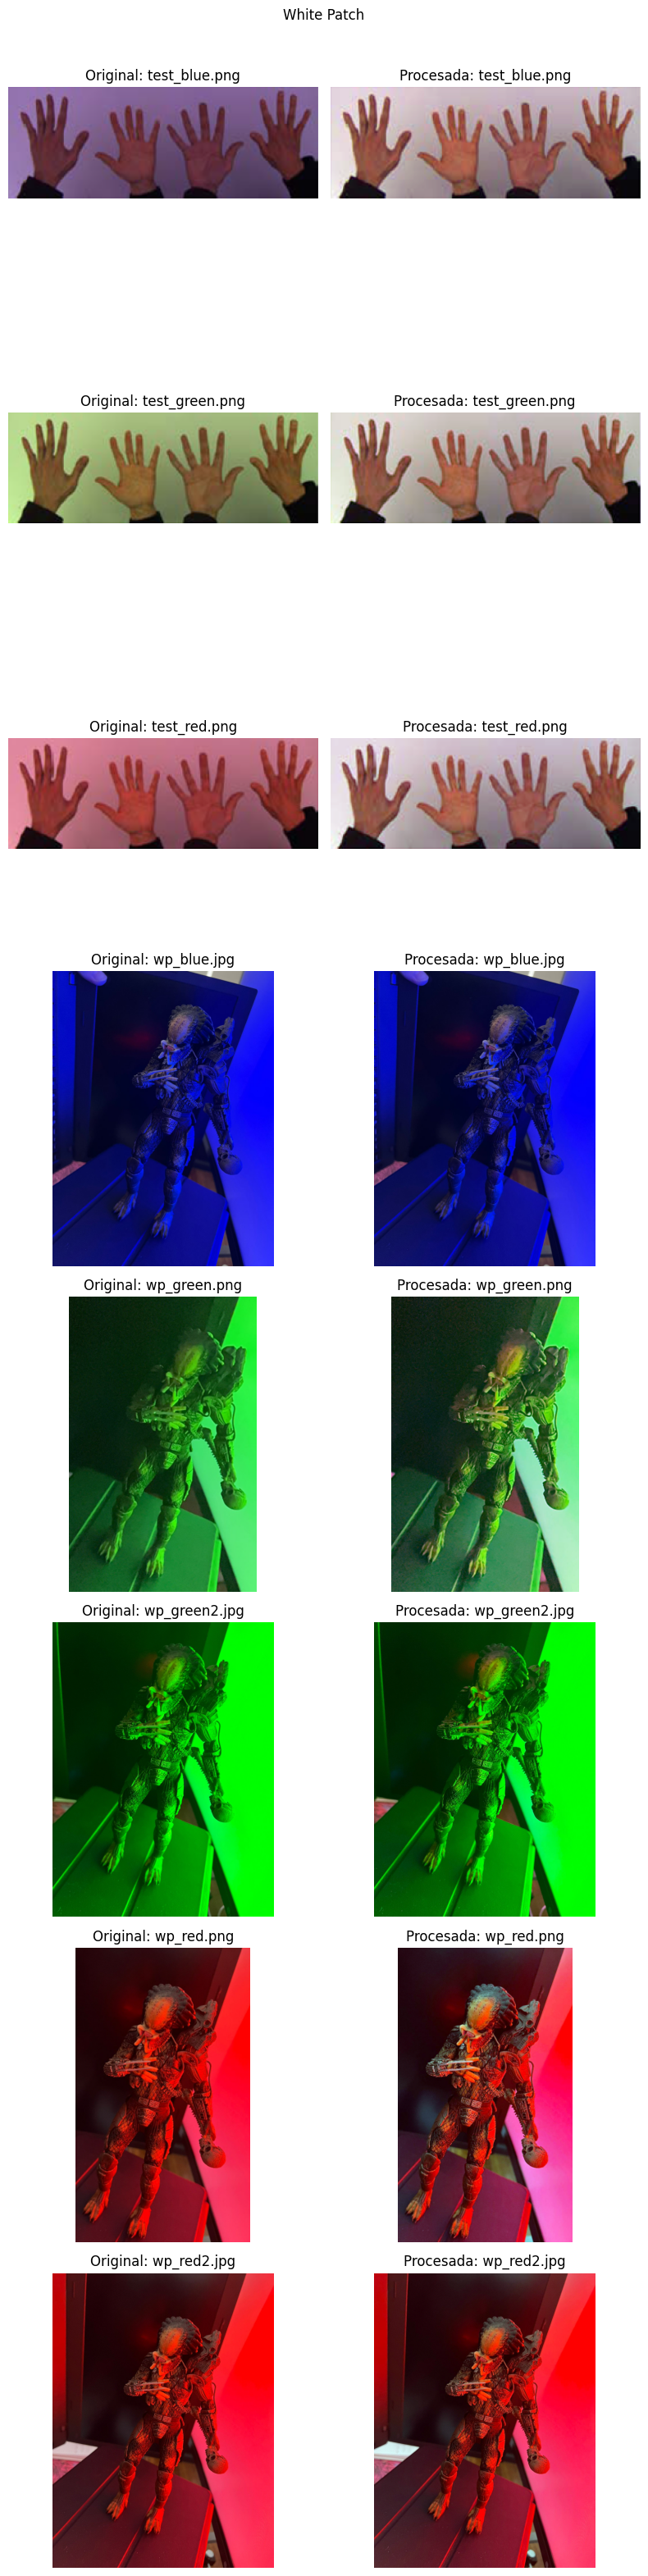

In [126]:
procesar_y_mostrar_imagenes('./white_patch',white_patch, "White Patch")


Posibles fallas de white patch:

- **Saturación**: El multiplicador que se utiliza para cada canal será siempre igual o mayor a 1 (ya que como mucho el máximo en el canal es 255). Esto podría producir que al multiplicar algunos píxeles queden con un valor mayor a 255, el cual será saturado a 255 ya que es el valor máximo de un unit8.
- **Uso de un máximo global y ruido**: Al utilizar un máximo global, con que un píxel en el canal tenga un valor anormal (por ejemplo una imagen oscura y un píxel en 255 producido por ruido o una anomalía) producirá que el máximo tenga un valor que nos representativo para ese canal, alterando el resultado del algoritmo.

### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘ features ’ a los
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.